In [141]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

In [142]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
del df['PassengerId'], df['Ticket']
submissionPIDs = test_df['PassengerId']
del test_df['PassengerId'], test_df['Ticket']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [143]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [144]:
df.at[61, "Embarked"] = "C" #Since name is french assign cherbourgh
df.at[829, "Embarked"] = "S" #The name here count be from either Ireland or England so 
                            #S is assigned since it is vastly more common
    
#for test data we will simply assign S
test_df['Embarked'].fillna('S', inplace=True)

In [145]:
df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
test_df['Fare'].fillna(np.mean(df['Fare']), inplace=True)

In [146]:
df['Cabin'].fillna(value = 'unknown', inplace=True)
test_df['Cabin'].fillna(value='unknown', inplace=True)

def cabin(cab, letters):
    for letter in letters:
        if letter in cab:
            return letter
    return None

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

df['Cabin'] = df['Cabin'].map(lambda x: cabin(x, letters))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: cabin(x, letters))

In [147]:
def title(name, titles):
    for title in titles:
        if title in name:
            return title
    return None

title_list = ['Mrs', 'Mr', 'Miss', 'Master']

df['Title'] = df['Name'].map(lambda x: title(x, title_list))
test_df['Title'] = test_df['Name'].map(lambda x: title(x, title_list))

def impute_Nones(x):
    if pd.isnull(x['Title']):
        if x['Sex'] == 'male':
            if x['Age'] <= 12:
                return 'Master'
            else:
                return 'Mr'
        elif x['Sex'] == 'female':
            if x['Age'] >= 23:
                return 'Mrs'
            else:
                return 'Miss'
    else:
        return x['Title']

df['Title'] = df.apply(impute_Nones, axis=1)
test_df['Title'] = df.apply(impute_Nones, axis=1)
del df['Name'], test_df['Name']

df['Title'].value_counts()

Mr        537
Miss      180
Mrs       134
Master     40
Name: Title, dtype: int64

mrs_mean_age: 35.47008547008547
mr_mean_age: 32.98441247002398
miss_mean_age: 21.77777777777778
master_mean_age: 4.574166666666667


<AxesSubplot:>

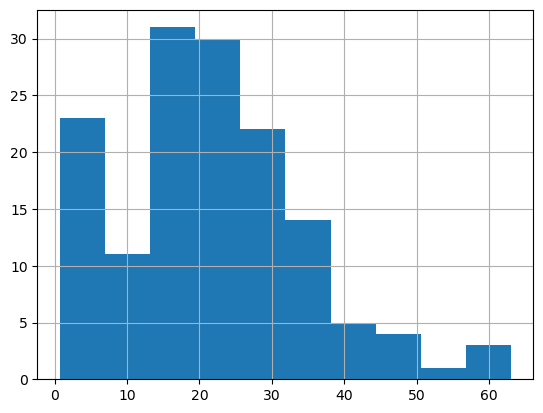

In [148]:
mrs = df.loc[df['Title'] == 'Mrs']
mrs_mean_age = np.mean(mrs['Age'])

mr = df.loc[df['Title'] == 'Mr']
mr_mean_age = np.mean(mr['Age'])

miss = df.loc[df['Title'] == 'Miss']
miss_mean_age = np.mean(miss['Age'])

master = df.loc[df['Title'] == 'Master']
master_mean_age = np.mean(master['Age'])

print('mrs_mean_age:', mrs_mean_age)
print('mr_mean_age:', mr_mean_age)
print('miss_mean_age:', miss_mean_age)
print('master_mean_age:', master_mean_age)
miss['Age'].hist()

In [149]:
def impute_ages(x):
    if pd.isnull(x['Age']):
        if x['Title'] == 'Mrs':
            return 35
        elif x['Title'] == 'Master':
            return 4.5
        elif x['Title'] == 'Miss':
            return 22
        else:
            return 33
    else:
        return x['Age']

df['Age'] = df.apply(impute_ages, axis=1)
test_df['Age'] = df.apply(impute_ages, axis=1)

In [151]:
df = pd.get_dummies(df, columns = ['Title', 'Embarked', 'Cabin'])
test_df = pd.get_dummies(test_df, columns = ['Title', 'Embarked', 'Cabin'])
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    object 
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Title_Master  891 non-null    uint8  
 8   Title_Miss    891 non-null    uint8  
 9   Title_Mr      891 non-null    uint8  
 10  Title_Mrs     891 non-null    uint8  
 11  Embarked_C    891 non-null    uint8  
 12  Embarked_Q    891 non-null    uint8  
 13  Embarked_S    891 non-null    uint8  
 14  Cabin_A       891 non-null    uint8  
 15  Cabin_B       891 non-null    uint8  
 16  Cabin_C       891 non-null    uint8  
 17  Cabin_D       891 non-null    uint8  
 18  Cabin_E       891 non-null    

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,0,3,male,22.0,1,0,7.2500,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1,1,female,38.0,1,0,71.2833,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,female,35.0,1,0,53.1000,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,3,male,35.0,0,0,8.0500,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [152]:
encoder = preprocessing.LabelEncoder()

features = ['Sex']
for feature in features:
    df[feature] = encoder.fit_transform(df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,0,3,1,22.0,1,0,7.2500,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,35.0,1,0,53.1000,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,3,1,35.0,0,0,8.0500,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [164]:
#make test and train data
y = df['Survived']
X = df.drop(['Survived'], axis=1)

X_submission = test_df

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [120]:
grid_size = 5
n_estimators = (np.linspace(10,200,grid_size,dtype=int))
learning_rates = np.logspace(start=-2, stop=1,num=grid_size)
max_depth = np.arange(1,3)
parameters = {'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rates}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, refit=True, cv=5)
clf = grid.fit(x_train,y_train)
grid.best_params_

{'learning_rate': 0.31622776601683794, 'max_depth': 2, 'n_estimators': 200}

In [162]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0)

print('cross_val_score: ', np.mean(cross_val_score(clf, X, y, cv=5)))
clf = clf.fit(x_train, y_train)

cross_val_score:  0.8283221392254095


In [165]:
clf1 = LogisticRegression(max_iter=1000).fit(x_train, y_train)
clf1.score(x_test, y_test)
print('cross_val_score: ', np.mean(cross_val_score(clf1, X, y, cv=5)))

cross_val_score:  0.8282970309459545


GradientBoost Metrics
Accuracy Score: 0.8283582089552238
F1 Score: 0.7386363636363635
roc_auc_score: 0.7992835968379447


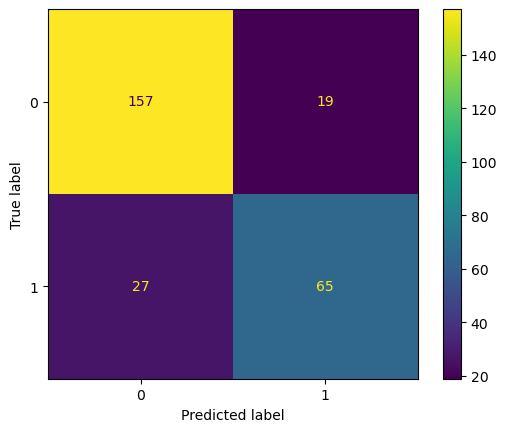

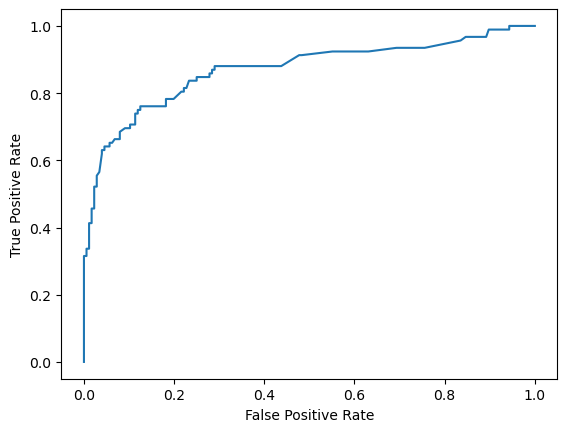

In [156]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels = [0, 1])
    cm_display = ConfusionMatrixDisplay(cm).plot()
    print('Accuracy Score:', accuracy_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('roc_auc_score:', roc_auc_score(y_test, y_pred))
    ypp = model.predict_proba(x_test)
    fpr, tpr, th = roc_curve(y_test, ypp[:,1], pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print('GradientBoost Metrics')
evaluate_model(clf, x_test, y_test)

Logistic Regression Metrics
Accuracy Score: 0.8379888268156425
F1 Score: 0.7851851851851852
roc_auc_score: 0.8213265835929388


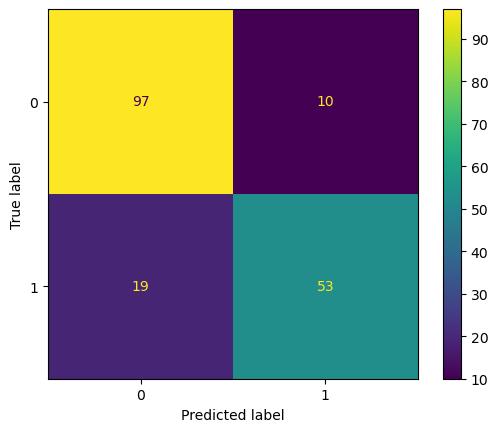

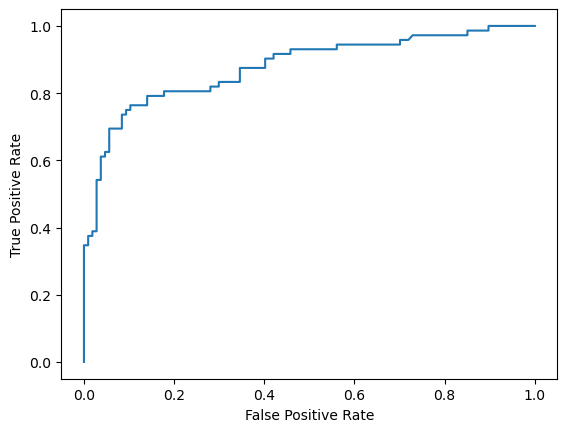

In [167]:
print('Logistic Regression Metrics')
evaluate_model(clf1, x_test, y_test)

In [166]:
submission_predictions = clf1.predict(X_submission)
submission = pd.DataFrame({'PassengerId':submissionPIDs, 'Survived':submission_predictions})
submission.to_csv('submission.csv', index=False)